First, let's load and explore the temperature.csv and BinSize.csv files.

In [20]:
import pandas as pd

# Load the datasets
temperature_data = pd.read_csv('temperature.csv')
binsize_data = pd.read_csv('BinSize.csv')

# Preview the data
temperature_data.head()


,ID,Date,Element,Data_Value
0,USW00094889,2014-11-12,TMAX,22
1,USC00208972,2009-04-29,TMIN,56
2,USC00200032,2008-05-26,TMAX,278
3,USC00205563,2005-11-11,TMAX,139
4,USC00200230,2014-02-27,TMAX,-106


Filter the data between 2005-2014 and clean it (removing leap days like February 29).

In [28]:
# Correct the Case
temperature_data.rename(columns={'Date': 'date'}, inplace=True)

# Convert date to datetime format
temperature_data['date'] = pd.to_datetime(temperature_data['date'])

# Filter for the years 2005-2014
temperature_data_filtered = temperature_data[
    (temperature_data['date'].dt.year >= 2005) & (temperature_data['date'].dt.year <= 2014)
]

# Remove leap day (February 29)
temperature_data_filtered = temperature_data_filtered[
    ~((temperature_data_filtered['date'].dt.month == 2) & (temperature_data_filtered['date'].dt.day == 29))
]

# Print the filtered data to check the output
print(temperature_data_filtered.head())


            ID       date Element  Data_Value
0  USW00094889 2014-11-12    TMAX          22
1  USC00208972 2009-04-29    TMIN          56
2  USC00200032 2008-05-26    TMAX         278
3  USC00205563 2005-11-11    TMAX         139
4  USC00200230 2014-02-27    TMAX        -106


To find record highs and lows, group the data by day of the year (MM-DD) and extract the minimum and maximum for each day.

In [33]:
# Extract day of the year (without the year) for grouping
temperature_data_filtered['day_of_year'] = temperature_data_filtered['date'].dt.strftime('%m-%d')

# Pivot the data to get TMAX and TMIN
pivot_data = temperature_data_filtered.pivot_table(
    index='day_of_year', columns='Element', values='Data_Value', aggfunc='max'
).reset_index()

# Rename the columns for clarity
pivot_data.columns = ['day_of_year', 'TMAX', 'TMIN']

# Print the pivot data to verify
print(pivot_data.head())


  day_of_year  TMAX  TMIN
0       01-01   156    72
1       01-02   139    28
2       01-03   133    28
3       01-04   106    44
4       01-05   128    94


Next, generate a line plot for the record high and low temperatures, shading the area between them

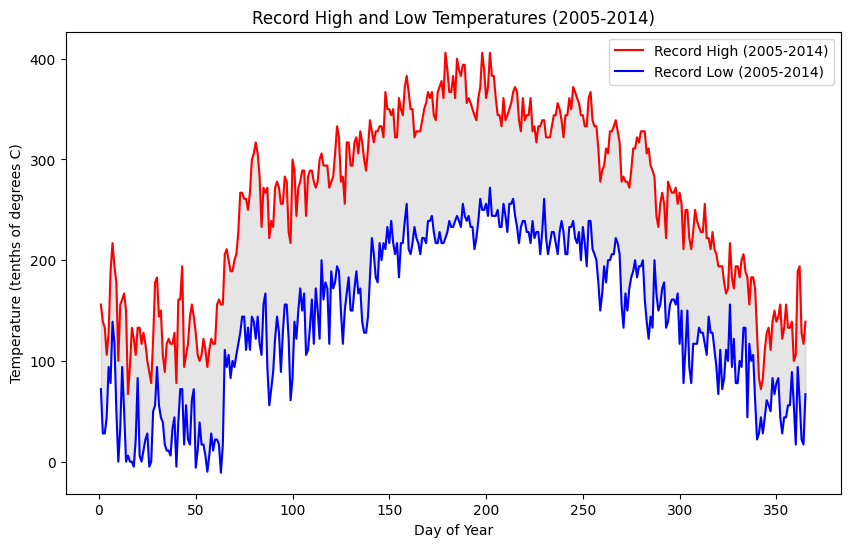

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Convert day_of_year to a range of days (1-365)
pivot_data['day_of_year_num'] = np.arange(1, len(pivot_data) + 1)

# Plotting record highs and lows
plt.figure(figsize=(10, 6))
plt.plot(pivot_data['day_of_year_num'], pivot_data['TMAX'], label='Record High (2005-2014)', color='red')
plt.plot(pivot_data['day_of_year_num'], pivot_data['TMIN'], label='Record Low (2005-2014)', color='blue')

# Fill between high and low temperatures
plt.fill_between(pivot_data['day_of_year_num'], pivot_data['TMAX'], pivot_data['TMIN'], color='gray', alpha=0.2)

# Add labels and title
plt.title('Record High and Low Temperatures (2005-2014)')
plt.xlabel('Day of Year')
plt.ylabel('Temperature (tenths of degrees C)')
plt.legend()
plt.show()


Now, let's compare 2015's data to see if any records (high or low) were broken.

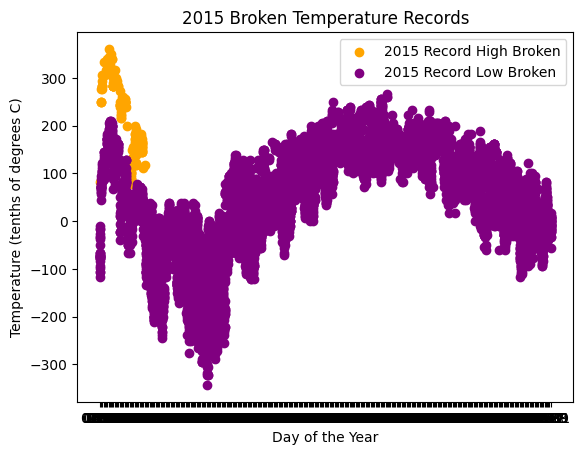

In [38]:
# Use .loc[] to avoid SettingWithCopyWarning
temperature_2015.loc[:, 'day_of_year'] = temperature_2015['date'].dt.strftime('%m-%d')

# Remove leap day (February 29)
temperature_2015 = temperature_2015[
    ~((temperature_2015['date'].dt.month == 2) & (temperature_2015['date'].dt.day == 29))
]

# Merge with the pivot data to compare
merged_data = pd.merge(pivot_data, temperature_2015, on='day_of_year', suffixes=('', '_2015'))

# Detect where records were broken by comparing TMAX and TMIN
record_high_broken = merged_data[merged_data['Data_Value'] > merged_data['TMAX']]
record_low_broken = merged_data[merged_data['Data_Value'] < merged_data['TMIN']]

# Scatter plot for broken records
plt.scatter(record_high_broken['day_of_year'], record_high_broken['Data_Value'], color='orange', label='2015 Record High Broken', zorder=5)
plt.scatter(record_low_broken['day_of_year'], record_low_broken['Data_Value'], color='purple', label='2015 Record Low Broken', zorder=5)

# Add labels, title, and legend
plt.xlabel('Day of the Year')
plt.ylabel('Temperature (tenths of degrees C)')
plt.title('2015 Broken Temperature Records')
plt.legend()

# Show plot
plt.show()


We'll visualize the station locations near Ann Arbor, Michigan using geopandas and folium.

In [ ]:
import geopandas as gpd
import folium
import pandas as pd

# Load station data
stations = pd.read_csv('BinSize.csv')

# Create a GeoDataFrame with the correct column names
stations_gdf = gpd.GeoDataFrame(
    stations,
    geometry=gpd.points_from_xy(stations['LONGITUDE'], stations['LATITUDE'])
)

# Create a folium map centered near Ann Arbor
map_ann_arbor = folium.Map(location=[42.2808, -83.7430], zoom_start=10)

# Add station markers to the map
for idx, row in stations_gdf.iterrows():
    folium.Marker([row['LATITUDE'], row['LONGITUDE']], popup=row['ID']).add_to(map_ann_arbor)

# Display the map
map_ann_arbor


Lastly, summarize the temperature data for 2015 near Ann Arbor, plotting the temperatures for that year.

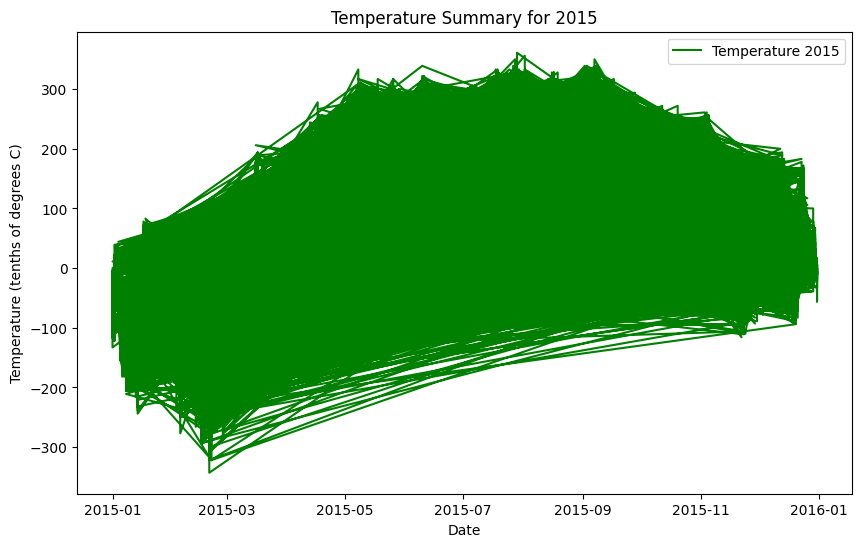

In [56]:
import matplotlib.pyplot as plt

# Convert date to datetime format
temperature_data['date'] = pd.to_datetime(temperature_data['date'])

# Filter for 2015 data
temperature_2015 = temperature_data[temperature_data['date'].dt.year == 2015]

# Plot the summary
plt.figure(figsize=(10, 6))
plt.plot(temperature_2015['date'], temperature_2015['Data_Value'], label='Temperature 2015', color='green')
plt.title('Temperature Summary for 2015')
plt.xlabel('Date')
plt.ylabel('Temperature (tenths of degrees C)')
plt.legend()
plt.show()
